# Combining LLMs with Random number generators for data generation

In this notebook, we will use functions to generate random age and income data, before we provide this information to an LLM to produce corresponding customer data (number of people in household, shopping list).

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import openai
import numpy as np
from tqdm import tqdm

## Define random data generation functions

We'll create functions to generate realistic age and income distributions.

In [2]:
def generate_random_age():
    """Generate a random age between 18 and 80 with a normal distribution centered at 40"""
    age = int(np.clip(np.random.normal(40, 12), 18, 80))
    return age

def generate_random_income():
    """Generate a random yearly income between 20000 and 150000 with a log-normal distribution"""
    income = np.random.lognormal(mean=11, sigma=0.5)
    return np.clip(income, 20000, 150000)

# Test the functions
print(f"Sample age: {generate_random_age()}")
print(f"Sample income: ${generate_random_income():.2f}")

Sample age: 69
Sample income: $32425.09


## Define the synthetic data generation function

We'll create a function that uses the LLM to generate customer data in JSON format, using our random age and income values.

In [3]:
def prompt_ollama(message:str, model="llama3.2"):
    """A prompt helper function that sends a message to ollama and returns only the text response."""
    if isinstance(message, str):
        message = [{"role": "user", "content": message}]
        
    # setup connection to the LLM
    import openai
    client = openai.OpenAI()
    client.base_url = "http://localhost:11434/v1"
    client.api_key = "none"
    response = client.chat.completions.create(
        model=model,
        messages=message
    )
    
    # extract answer
    return response.choices[0].message.content

def prompt(age: int, income: float) -> str:
    prompt_text = f"""Generate one realistic customer profile in valid JSON format with the following structure:
    {{
        'name': str,
        'gender': str (use only 'Male' or 'Female' or 'Other'),
        'age': {age},
        'income': {income:.2f},
        'household_size': int,
        'grocery_list': [
            {{'item': str, 'price': float}},
            ...
        ]
    }}
    Include 5-10 grocery items with realistic prices.
    
    Respond with the JSON data only and no markdown fences."""
    return prompt_ollama(prompt_text)

# Test the function
sample_data = prompt(generate_random_age(), generate_random_income())
print(sample_data)

{"name": "John Doe", "gender": "Male", "age": 24, "income": 115030.14, "household_size": 3, "grocery_list": [{"item": "Milk", "price": 2.9}, {"item": "Eggs", "price": 1.89}, {"item": "Bread", "price": 2.49}, {"item": "Apples", "price": 3.19}, {"item": "Chicken breasts", "price": 8.99}, {"item": "Oatmeal", "price": 4.99}, {"item": "Granola bars", "price": 5.29}, {"item": "Yogurt", "price": 2.7}, {"item": "Almond milk", "price": 3.69}, {"item": "Salad mix", "price": 3.98}]}


## Collect and validate customer records

We'll generate 100 customer records using random age and income values, and validate the JSON format.

In [4]:
customer_records = []

for i in tqdm(range(100)):
    try:
        age = generate_random_age()
        income = generate_random_income()
        data = prompt(age, income)
        # Validate JSON
        customer_data = json.loads(data)
        customer_records.append(customer_data)
    except json.JSONDecodeError:
        print(f"Invalid JSON format in record {i+1}")

print(f"\nCollected {len(customer_records)} valid customer records")

  6%|████▏                                                                | 6/100 [02:55<41:24, 26.43s/it]

Invalid JSON format in record 6


 19%|████████████▉                                                       | 19/100 [06:56<21:48, 16.16s/it]

Invalid JSON format in record 19


 23%|███████████████▋                                                    | 23/100 [07:21<11:16,  8.79s/it]

Invalid JSON format in record 23


 42%|████████████████████████████▌                                       | 42/100 [09:23<05:36,  5.80s/it]

Invalid JSON format in record 42


 75%|███████████████████████████████████████████████████                 | 75/100 [17:26<06:52, 16.48s/it]

Invalid JSON format in record 75


100%|███████████████████████████████████████████████████████████████████| 100/100 [23:48<00:00, 14.29s/it]


Collected 95 valid customer records


## Transform data into a DataFrame

We'll create the DataFrame with customer information and calculate total weekly grocery spending.

In [5]:
# Extract customer info
customer_info = []
for record in customer_records:
    try:
        # Calculate total spending
        total_spending = sum(item['price'] for item in record['grocery_list'])
        
        customer_info.append({
            'name': record['name'],
            'gender': record['gender'],
            'age': record['age'],
            'income': record['income'],
            'household_size': record['household_size'],
            'weekly_spending': total_spending
        })
    except:
        print("Error processing record")

df = pd.DataFrame(customer_info)
display(df)

,name,gender,age,income,household_size,weekly_spending
0,John Smith,Male,55,31103.59,2,34.22
1,John Doe,Male,55,44309.50,2,44.82
2,Emily Wilson,Female,40,55420.05,2,35.26
3,John Doe,Male,28,38668.96,2,38.16
4,John Doe,Male,46,47704.73,3,37.48
...,...,...,...,...,...,...
90,John Smith,Male,39,116377.04,3,41.14
91,John Doe,Male,37,40804.52,3,30.09
92,John Doe,Male,31,32088.77,3,28.90
93,John Doe,Male,38,150000.00,4,40.10


## Visualize relationships in the data

Let's create several plots to analyze relationships between variables:

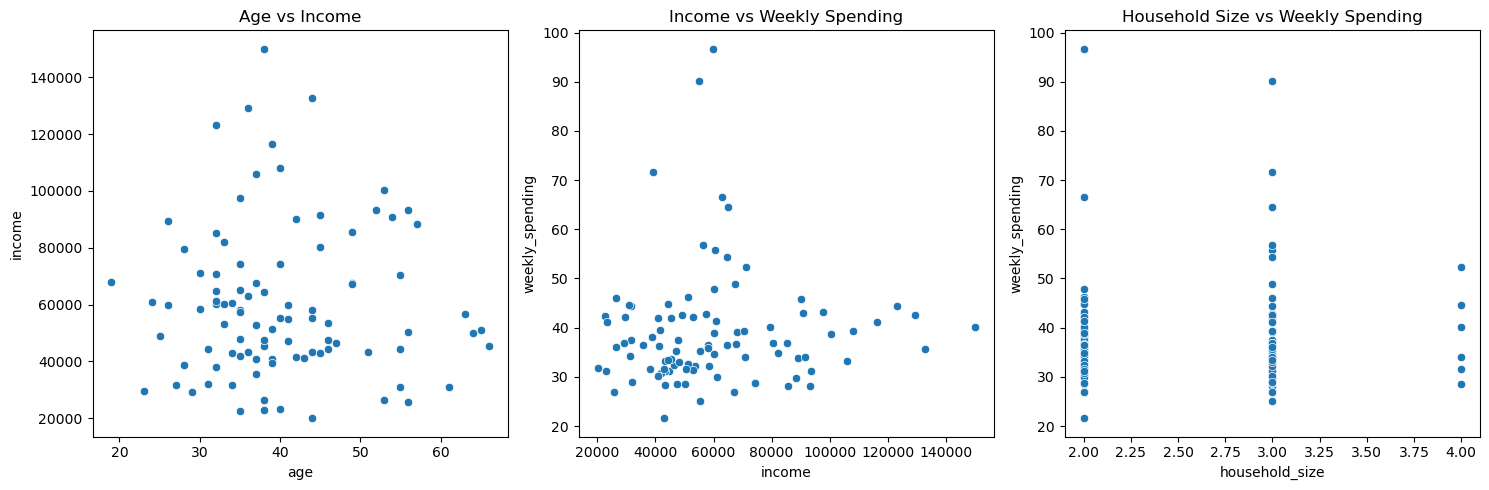

In [6]:
# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Age vs Income
sns.scatterplot(data=df, x='age', y='income', ax=ax1)
ax1.set_title('Age vs Income')

# Income vs Weekly Shopping
sns.scatterplot(data=df, x='income', y='weekly_spending', ax=ax2)
ax2.set_title('Income vs Weekly Spending')

# Household Size vs Weekly Shopping
sns.scatterplot(data=df, x='household_size', y='weekly_spending', ax=ax3)
ax3.set_title('Household Size vs Weekly Spending')

plt.tight_layout()
plt.show()

## Additional Analysis: Shopping patterns by gender

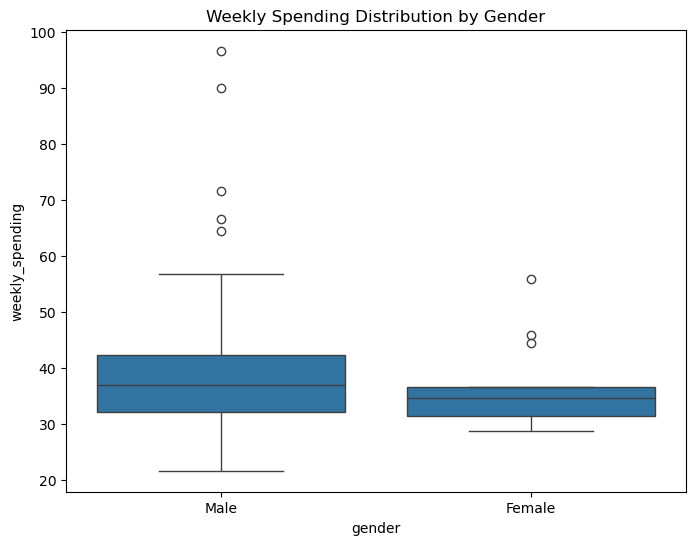

In [7]:
# Box plot of weekly spending by gender
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='gender', y='weekly_spending')
plt.title('Weekly Spending Distribution by Gender')
plt.show()

## Exercise
Modify the prompt to ensure that the average money spent per week is higher, the more people live in the household. 
Also assuming that people have kids in certain age ranges, the number of people per houshold versus age could show a certain pattern. 